<a href="https://colab.research.google.com/github/drkaushiksarkar/sentiment_analysis/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis: Digital Content and Entertainment Industry**

In [ ]:
import os
import pandas as pd
import numpy as np


import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from sklearn.metrics import roc_auc_score, roc_curve


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!mkdir -p dense_model_output

In [ ]:
os.chdir('dense_model_output')

Setting Dense Sentiment Classifier Hyperparameters

In [ ]:
# output directory name: store model parameters after each epoch
output_dir = 'dense_model_output'

# training: using less number of epochs as NLP models have the tendency to overfit to the training data
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 10000 # using a max vocabulary size of 10,000
n_words_to_skip = 0 
max_review_length = 20 # using the first 20 words from each review to speed up training
pad_type = trunc_type = 'post' # as instructed trancating the reviews after first 20 words

# neural network architecture:
n_dense = 64
dropout = 0.5

Import and analyze the dataset

In [ ]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words = n_unique_words, skip_top= n_words_to_skip)

17473536/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

Printing the number of tokens in 5 reviews

In [ ]:
for x in x_train[0:5]:
  print(len(x))

218
189
141
550
147


To view the reviews as natural language, below I have created an index of words, where PAD, START, and UNK represents padding, starting, and unknown tokens, respectively.

1.   List item
2.   List item



In [ ]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = {v:k for k, v in word_index.items()}

1654784/1641221 [==============================] - 0s 0us/step


Printing the first review as natural language

In [ ]:
' '.join(index_word[id] for id in x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little boy's that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have d

Standardizing input length by padding sequences and truncating

In [ ]:
x_train = pad_sequences(x_train, maxlen = max_review_length, padding = pad_type, truncating = trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen = max_review_length, padding = pad_type, truncating = trunc_type, value=0)

Print shape of features and labels

In [ ]:
x_train.shape

(25000, 20)

In [ ]:
y_train.shape

(25000,)

Print value of any one feature and label

In [ ]:
x_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25], dtype=int32)

In [ ]:
y_train[0]

1

Decode the feature value to get original sentence

In [ ]:
' '.join(index_word[id] for id in x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you"

Dense sentiment classifier architecture

In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation= 'relu'))
model.add(Dropout(dropout))
model.add(Dense(n_dense, activation= 'relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 64)            640000    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

compiling the sentiment classifier model and creating the object and directory for check[point after each epoch

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

Fitting the classifier

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data = (x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 16s 10ms/step - loss: 0.6885 - accuracy: 0.5270 - val_loss: 0.5899 - val_accuracy: 0.6770
Epoch 2/4
196/196 [==============================] - 1s 7ms/step - loss: 0.5053 - accuracy: 0.7567 - val_loss: 0.5850 - val_accuracy: 0.6902
Epoch 3/4
196/196 [==============================] - 1s 7ms/step - loss: 0.2646 - accuracy: 0.8988 - val_loss: 0.7771 - val_accuracy: 0.6671
Epoch 4/4
196/196 [==============================] - 1s 7ms/step - loss: 0.1082 - accuracy: 0.9648 - val_loss: 1.1497 - val_accuracy: 0.6587


loading model hyperparameters

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5")

predicting y_hat for validation set

In [ ]:
y_hat = model.predict_proba(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
' '.join(index_word[id] for id in x_valid[15])

"START let me first start out by saying 1 out of 10 is too good for this movie it's unfortunate"

In [ ]:
y_hat[15]

array([0.14665964], dtype=float32)

In [ ]:
y_valid[15]

0

plotting a histogram of validation set y_hat values

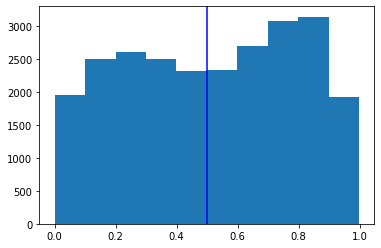

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='blue')

Calculating the area under the curve for validation data

In [ ]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'76.29'

Creating a dataframe for predicted and actual y values in the validation set

In [ ]:
float_y_hat = []
for y in y_hat:
  float_y_hat.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns = ['y_hat', 'y'])

20 cases of negative validation reviews with high y score

In [ ]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(20)

,y_hat,y
114,0.921927,0
147,0.933281,0
166,0.939785,0
306,0.930153,0
310,0.922354,0
383,0.927112,0
449,0.956559,0
495,0.956936,0
553,0.936394,0
623,0.900151,0


20 cases of positive valiadtion reviews with low y score

In [ ]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.5)].head(20)

,y_hat,y
5,0.354997,1
9,0.133904,1
16,0.314335,1
22,0.362785,1
27,0.142828,1
41,0.494979,1
53,0.350206,1
54,0.453459,1
56,0.222107,1
69,0.154366,1


Effort to produce a more complex CNN model with better accuracy

In [ ]:
# output directory name: store model parameters after each epoch
output_dir = 'conv_model_output'

# training: using less number of epochs as NLP models have the tendency to overfit to the training data
epochs = 10
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 10000 # using a max vocabulary size of 10,000
max_review_length = 20 # using the first 20 words from each review to speed up training
pad_type = trunc_type = 'pre' # as instructed trancating the reviews after first 20 words
drop_embed = 0.2

# neural network architecture:
n_conv = 256
k_conv = 3
n_dense = 256
dropout = 0.2

In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation= 'relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data = (x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/10
196/196 [==============================] - 5s 15ms/step - loss: 0.6663 - accuracy: 0.5706 - val_loss: 0.5638 - val_accuracy: 0.6965
Epoch 2/10
196/196 [==============================] - 3s 13ms/step - loss: 0.4765 - accuracy: 0.7745 - val_loss: 0.5683 - val_accuracy: 0.7046
Epoch 3/10
196/196 [==============================] - 3s 13ms/step - loss: 0.3757 - accuracy: 0.8361 - val_loss: 0.6121 - val_accuracy: 0.6991
Epoch 4/10
196/196 [==============================] - 3s 13ms/step - loss: 0.2702 - accuracy: 0.8940 - val_loss: 0.7102 - val_accuracy: 0.6867
Epoch 5/10
196/196 [==============================] - 3s 13ms/step - loss: 0.1797 - accuracy: 0.9332 - val_loss: 0.9001 - val_accuracy: 0.6837
Epoch 6/10
196/196 [==============================] - 2s 13ms/step - loss: 0.1069 - accuracy: 0.9637 - val_loss: 1.0491 - val_accuracy: 0.6753
Epoch 7/10
196/196 [==============================] - 3s 13ms/step - loss: 0.0679 - accuracy: 0.9780 - val_loss: 1.2653 - val_accuracy: 0.6718

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [ ]:
y_hat = model.predict_proba(x_valid);

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'78.20'

**Section 2. Social Media Analytics**

Read and explore the data

In [ ]:
url = 'https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json'


In [ ]:
df= pd.read_json(url, lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

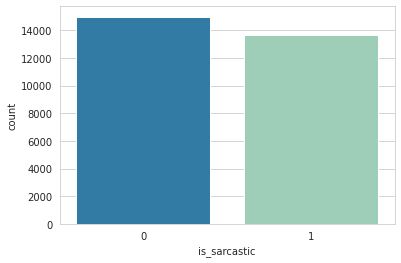

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic',data=df, palette='YlGnBu_r');

Retain relevant columns

In [ ]:
df = df.drop("article_link", axis = 1)

Get length of each sentence

In [ ]:
df['length of sentence'] = df.headline.apply(lambda x: len(str(x).split(' ')))
df.head()

,is_sarcastic,headline,length of sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


Preprocessing

In [ ]:
# remove unwanted characters but keep the alphanum
pattern = "[^\w ]"
df.headline = df.headline.apply(lambda s : re.sub(pattern,"",s))

In [ ]:
#covert all texts in text columns into lower case
df.headline = df.headline.apply(lambda s: s.lower())

In [ ]:
#remove unwanted spaces
df.headline = df.headline.apply(lambda s: s.strip())

In [ ]:
stopwords = set(stopwords.words('english'))
df.headline = df.headline.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [ ]:
#recheck data
df.head()

,is_sarcastic,headline,length of sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep totally nails congress falling short g...,13
2,0,eat veggies 9 deliciously different recipes,7
3,1,inclement weather prevents liar getting work,8
4,1,mother comes pretty close using word streaming...,9


Create feature and labels


In [ ]:
from sklearn.model_selection import train_test_split
X=df['headline'].values
y=df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Define parameters, Tokenize and get indices for words

In [ ]:
vocab_size=10000
embedding_dim=100
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Build a dense network first

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                102432    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Create weight matrix using GloVe embeddings

In [ ]:
!mkdir -p dense_model_output

In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
!pwd
!ls

In [ ]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
glove_dir = '/content/drive/MyDrive'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
  if i<vocab_size:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Adding the weights from the glove embedding

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=training_padded, y=y_train, batch_size=256, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
79/79 [==============================] - 2s 15ms/step - loss: 0.7081 - accuracy: 0.5243 - val_loss: 0.6815 - val_accuracy: 0.5811
Epoch 2/100
79/79 [==============================] - 1s 11ms/step - loss: 0.6874 - accuracy: 0.5440 - val_loss: 0.6702 - val_accuracy: 0.6251
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 0.6741 - accuracy: 0.5650 - val_loss: 0.6533 - val_accuracy: 0.6529
Epoch 4/100
79/79 [==============================] - 1s 10ms/step - loss: 0.6599 - accuracy: 0.5915 - val_loss: 0.6353 - val_accuracy: 0.6740
Epoch 5/100
79/79 [==============================] - 1s 10ms/step - loss: 0.6466 - accuracy: 0.6157 - val_loss: 0.6191 - val_accuracy: 0.6915
Epoch 6/100
79/79 [==============================] - 1s 10ms/step - loss: 0.6379 - accuracy: 0.6263 - val_loss: 0.6075 - val_accuracy: 0.7056
Epoch 7/100
79/79 [==============================] - 1s 10ms/step - loss: 0.6234 - accuracy: 0.6405 - val_loss: 0.5946 - val_accuracy: 0.7156
Epoch 

In [ ]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,43)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.699871,0.524784,0.681495,0.581062,1
2,0.685754,0.545899,0.670211,0.625087,2
3,0.670354,0.572406,0.653330,0.652923,3
4,0.657690,0.593970,0.635319,0.674004,4
5,0.643332,0.619777,0.619087,0.691474,5
6,0.634866,0.628812,0.607478,0.705567,6
7,0.622120,0.643388,0.594553,0.715584,7
8,0.612615,0.652673,0.583778,0.719660,8
9,0.600648,0.663455,0.570825,0.728162,9


In [ ]:
score = model.evaluate(testing_padded, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

135/135 [==============================] - 0s 1ms/step - loss: 0.4422 - accuracy: 0.8061
Test accuracy: 0.8060796856880188


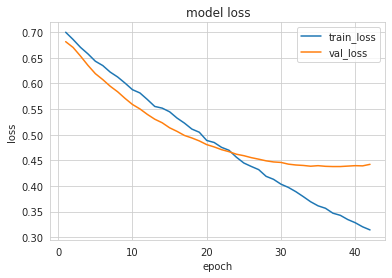

In [ ]:
#Loss Graph(Training and Validation)
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

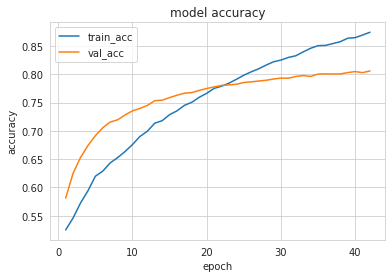

In [ ]:
# Accuracy Graph(Training and Validation) 
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

Building the CNN Model

In [ ]:
model_conv = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(16,3,activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 16)            4816      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 1446      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [ ]:
model_conv.layers[0].set_weights([embedding_matrix])
model_conv.layers[0].trainable = False
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model_conv.fit(training_padded, y_train, batch_size=256, epochs=20, validation_data=(testing_padded, y_test), callbacks=[early_stop])

Epoch 1/20
79/79 [==============================] - 2s 14ms/step - loss: 0.6892 - accuracy: 0.5328 - val_loss: 0.6385 - val_accuracy: 0.6558
Epoch 2/20
79/79 [==============================] - 1s 9ms/step - loss: 0.6089 - accuracy: 0.6684 - val_loss: 0.5527 - val_accuracy: 0.7268
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 0.5495 - accuracy: 0.7190 - val_loss: 0.5298 - val_accuracy: 0.7410
Epoch 4/20
79/79 [==============================] - 1s 9ms/step - loss: 0.5180 - accuracy: 0.7435 - val_loss: 0.5155 - val_accuracy: 0.7517
Epoch 5/20
79/79 [==============================] - 1s 9ms/step - loss: 0.5029 - accuracy: 0.7539 - val_loss: 0.5062 - val_accuracy: 0.7572
Epoch 6/20
79/79 [==============================] - 1s 9ms/step - loss: 0.4996 - accuracy: 0.7520 - val_loss: 0.4992 - val_accuracy: 0.7596
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.4721 - accuracy: 0.7755 - val_loss: 0.4964 - val_accuracy: 0.7595
Epoch 8/20
79/79 

Building the LSTM Model

In [ ]:
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 32, 100)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 1,034,445
Trainable params: 1,034,445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.layers[0].set_weights([embedding_matrix])
model_lstm.layers[0].trainable = False

Fit the model and check validation accuracy

In [ ]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_lstm = model_lstm.fit(x=training_padded, y=y_train, batch_size=64, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
314/314 [==============================] - 20s 52ms/step - loss: 0.6131 - accuracy: 0.6591 - val_loss: 0.5258 - val_accuracy: 0.7452
Epoch 2/100
314/314 [==============================] - 16s 50ms/step - loss: 0.4895 - accuracy: 0.7620 - val_loss: 0.4689 - val_accuracy: 0.7774
Epoch 3/100
314/314 [==============================] - 15s 49ms/step - loss: 0.4331 - accuracy: 0.7927 - val_loss: 0.4623 - val_accuracy: 0.7802
Epoch 4/100
314/314 [==============================] - 15s 48ms/step - loss: 0.4043 - accuracy: 0.8111 - val_loss: 0.5075 - val_accuracy: 0.7570
Epoch 5/100
314/314 [==============================] - 15s 48ms/step - loss: 0.3823 - accuracy: 0.8211 - val_loss: 0.4440 - val_accuracy: 0.7935
Epoch 6/100
314/314 [==============================] - 15s 49ms/step - loss: 0.3318 - accuracy: 0.8524 - val_loss: 0.4754 - val_accuracy: 0.7793
Epoch 7/100
314/314 [==============================] - 16s 51ms/step - loss: 0.3097 - accuracy: 0.8647 - val_loss: 0.4453 - val_ac

In [ ]:
score = model_lstm.evaluate(testing_padded, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

135/135 [==============================] - 2s 15ms/step - loss: 0.5291 - accuracy: 0.8033
Test accuracy: 0.8032844066619873


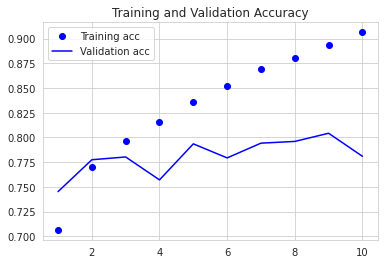

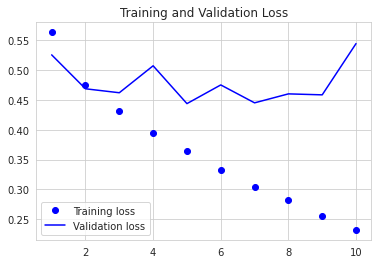

In [ ]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

This model did not perform very well compared to the other base models. One particular reason is that my inputs only consider first 32 words, rather than full sequences. Another reason may be not experimenting much with the embedding dimensionality or the LSTM output. Another reason can be the lesser try with regularization. However, the primary reason here is that analyzing the global long term structure of the reviews isn't helpful in solving the problem. 